In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from sklearn.linear_model import LogisticRegression   
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve,auc
from sklearn.model_selection import GridSearchCV
import xgboost
import matplotlib.pyplot as plt
from sklearn.metrics import log_loss

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import cross_val_score
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.externals import joblib
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
group=pd.read_csv('Group_xx.csv')
train=pd.read_csv('train.csv')
validation=pd.read_csv('validation.csv')
test=pd.read_csv('test.csv')

In [5]:
train=train[train.payprice>=train.slotprice]
validation=validation[validation.payprice>=validation.slotprice]

In [6]:
train['size']=train['slotwidth']*train['slotheight']
validation['size']=validation['slotwidth']*validation['slotheight']
test['size']=test['slotwidth']*test['slotheight']

train['OS'], train['browser'] = zip(*train['useragent'].map(lambda x: x.split('_')))
validation['OS'], validation['browser'] = zip(*validation['useragent'].map(lambda x: x.split('_')))
test['OS'], test['browser'] = zip(*test['useragent'].map(lambda x: x.split('_')))

In [7]:
def pre_process_data(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
    
    df.ix[df.slotprice.between(0, 10), 'slotpricebucket'] = 1
    df.ix[df.slotprice.between(11, 50), 'slotpricebucket'] = 2
    df.ix[df.slotprice.between(51, 100), 'slotpricebucket'] = 3
    df.ix[df.slotprice.between(101, 5000), 'slotpricebucket'] = 4
    df['slotpricebucket'] = df['slotpricebucket'].astype(np.uint8)

    pred=df.drop(['click','bidid','userid','IP','url','urlid','slotid','useragent','slotprice',
                 'bidprice','payprice','domain','slotwidth', 'slotheight'],axis=1)
    
    # create dummy variables for categoricals
    pred=pd.get_dummies(pred,dummy_na=True,columns=['weekday', 'hour', 
                                                       'OS', 'browser', 
                                                       'region', 'city', 'adexchange', 
                                                       'slotvisibility', 'slotformat',
                                                       'creative', 'slotpricebucket','advertiser'##'ip_block'
                                                    ,'keypage','size'])
    pred = pred.join(df.usertag.astype(str).str.strip('[]').str.get_dummies(','))
    pred=pred.drop(['usertag'],axis=1)
    print("After converting categoricals:\t{}".format(pred.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(pred.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, pred.columns)
        print(to_add)
        print(to_drop)
        pred.drop(to_drop, axis=1, inplace=True)
        pred = pred.assign(**{c: 0 for c in to_add})
    
    pred.fillna(0, inplace=True)
    
    return pred


def pre_process_data_test(df, enforce_cols=None):
    print("Input shape:\t{}".format(df.shape))
    
    df.ix[df.slotprice.between(0, 10), 'slotpricebucket'] = 1
    df.ix[df.slotprice.between(11, 50), 'slotpricebucket'] = 2
    df.ix[df.slotprice.between(51, 100), 'slotpricebucket'] = 3
    df.ix[df.slotprice.between(101, 5000), 'slotpricebucket'] = 4
    df['slotpricebucket'] = df['slotpricebucket'].astype(np.uint8)

    pred=df.drop(['bidid','userid','IP','url','urlid','slotid','useragent','slotprice',
                 'domain','slotwidth', 'slotheight'],axis=1)
    
       # create dummy variables for categoricals
    pred=pd.get_dummies(pred,dummy_na=True,columns=['weekday', 'hour',  # ])
                                                       'OS', 'browser', 
                                                       'region', 'city', 'adexchange', 
                                                       'slotvisibility', 'slotformat',
                                                       'creative', 'slotpricebucket','advertiser'##'ip_block'
                                                    ,'keypage','size'])
    pred = pred.join(df.usertag.astype(str).str.strip('[]').str.get_dummies(','))
    pred=pred.drop(['usertag'],axis=1)
    print("After converting categoricals:\t{}".format(pred.shape))
    

    # match test set and training set columns
    if enforce_cols is not None:
        to_drop = np.setdiff1d(pred.columns, enforce_cols)
        to_add = np.setdiff1d(enforce_cols, pred.columns)
        print(to_add)
        print(to_drop)
        pred.drop(to_drop, axis=1, inplace=True)
        pred = pred.assign(**{c: 0 for c in to_add})
    
    pred.fillna(0, inplace=True)
    
    return pred

In [8]:
train_dum = pre_process_data(train)
valid_dum = pre_process_data(validation,enforce_cols=train_dum.columns)
test_dum = pre_process_data_test(test,enforce_cols=train_dum.columns)

Input shape:	(2418578, 28)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.


After converting categoricals:	(2418578, 741)
Input shape:	(302408, 28)
After converting categoricals:	(302408, 739)
['creative_7324' 'creative_7332']
[]
Input shape:	(303375, 25)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:42: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


After converting categoricals:	(303375, 739)
['creative_7324' 'creative_7327']
[]


In [9]:
y = train.click
y_validation = validation.click

In [10]:
def order(df_test, df_train):
    new_df = pd.DataFrame()
    
    for key in df_train:
        new_df[key] = df_test[key]
    return new_df
X_validation = order(valid_dum,train_dum)
X_test = order(test_dum,train_dum)

In [107]:
rus = RandomUnderSampler(random_state=3,ratio={1:1786,0:10758})
X_train,y_train = rus.fit_sample(train_dum,y)

In [108]:
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
clf1 = LogisticRegression(penalty='l1', max_iter=100, C=0.1,solver='saga',class_weight='unbalanced')
#clf2 = KNeighborsClassifier(n_neighbors=3)
#clf3 = GaussianNB()
#clf4 = SVC(C = 0.1,kernel='sigmoid',gamma='auto',tol=0.001,max_iter=10,probability=True)
clf5 = RandomForestClassifier(n_estimators=100, random_state=3)

In [71]:
import lightgbm as lgb

In [73]:
clf6 = lgb.LGBMClassifier(max_depth=6, n_estimators=100, learning_rate=0.05, silent = 0,
                             subsample = 0.8, min_child_weight=3,
                             colsample_bytree=0.8)

In [16]:
clf1.fit(X_train,y_train)
clf5.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=3, verbose=0, warm_start=False)

In [109]:
clf6.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=3, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None, silent=0,
       subsample=0.8)

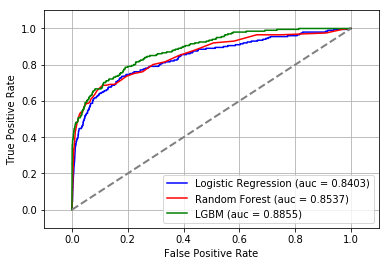

In [75]:
y_valid1 = clf1.predict_proba(X_validation.as_matrix())
y_valid2 = clf5.predict_proba(X_validation.as_matrix())
y_valid3 = clf6.predict_proba(X_validation.as_matrix())
fpr1, tpr1, thresholds1 = roc_curve(y_validation, y_valid1[:,1]) 
fpr2, tpr2, thresholds2 = roc_curve(y_validation, y_valid2[:,1])
fpr3, tpr3, thresholds3 = roc_curve(y_validation, y_valid3[:,1])
roc_auc1 = auc(x=fpr1, y=tpr1)
roc_auc2 = auc(x=fpr2, y=tpr2)
roc_auc3 = auc(x=fpr3, y=tpr3)
linestyles = [':', '--', '-.', '--','-']
plt.plot(fpr1, tpr1,color='blue',
         label='%s (auc = %0.4f)' % ('Logistic Regression', roc_auc1))
plt.plot(fpr2, tpr2,color='red',
         label='%s (auc = %0.4f)' % ('Random Forest', roc_auc2))
plt.plot(fpr3, tpr3,color='green',
         label='%s (auc = %0.4f)' % ('LGBM', roc_auc3))
plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('auc.png')
plt.show()

In [24]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_validation, y_valid1[:,1])

0.022844183973849033

In [76]:
mean_squared_error(y_validation, y_valid3[:,1])

0.016233092339062623

In [128]:

y_valid2 = clf6.predict_proba(X_validation.as_matrix())
#y_valid3 = clf5.predict_proba(X_validation.as_matrix())

In [27]:
clf5 = RandomForestClassifier(n_estimators=100, random_state=3)
clf5.fit(X_train,y_train)
y_scores=clf5.predict_proba(X_validation.as_matrix())
roc_auc_score(y_validation, y_scores[:,1])

0.8536950234120932

# ortb1

In [100]:
result=pd.DataFrame(columns=['lambda','c_value','imps','cost','click'])

In [ ]:
y_test = clf6.predict_proba(X_test.as_matrix())
y_valid = clf6.predict_proba(X_validation.as_matrix())
# y_test = clf1.predict_proba(X_test.as_matrix())
# y_valid = clf1.predict_proba(X_validation.as_matrix())
# y_test = clf5.predict_proba(X_test.as_matrix())
# y_valid = clf5.predict_proba(X_validation.as_matrix())
#y_test=classifier.predict_proba(te)
w=10716/train.shape[0]
#print(w)
test_score=y_test[:,1]/(y_test[:,1]+(1-y_test[:,1])/w)
score=y_valid[:,1]/(y_valid[:,1]+(1-y_valid[:,1])/w)


max_num=0
max_bid=0
s=0
best_lambda=0
c_op=0
lambda_range=[1e-6]
iteration=0#

for c in np.arange(10,26 ,2):
    for m in lambda_range:
        num_click=0
        flag=True
        imp=0
        s=0
        size = validation.shape[0]
        iteration+=1
        for i in range(validation.shape[0]):
            bid = np.sqrt(c / m * score[i] + c ** 2) - c
            #onethird=(score[i]+np.sqrt((c**2) * (m**2)+score[i]**2))/(c*m)
            #bid=(onethird**(1/3)-onethird**(-1/3))*c
            if bid>validation.payprice[i] and flag:
                #print('yes')
                s=s+validation.payprice[i]
                if s>6250000:
                    s=s-validation.payprice[i]
                    flag=False
                    break
                num_click=num_click+validation.click[i]
                imp=imp+1
        result.loc[iteration,'c_value']=c
        result.loc[iteration,'lambda']=m
        result.loc[iteration,'click']=num_click
        result.loc[iteration,'cost']=s
        result.loc[iteration,'imps']=imp
    print(num_click)
    if num_click>max_num:
        print('increase')
        max_num=num_click
        max_bid=c
        
result['CTR']=result['click']/result['imps']
result['eCPC']=result['cost']/result['click']/1000
result['CPM']=result['cost']/result['imps']

In [116]:
result['cost']=result['cost']/1000

# ortb2

In [44]:
result=pd.DataFrame(columns=['lambda','c_value','imps','cost','click'])
y_test = clf6.predict_proba(X_test.as_matrix())
y_valid = clf6.predict_proba(X_validation.as_matrix())
# y_test = clf1.predict_proba(X_test.as_matrix())
# y_valid = clf1.predict_proba(X_validation.as_matrix())
# y_test = clf5.predict_proba(X_test.as_matrix())
# y_valid = clf5.predict_proba(X_validation.as_matrix())
#y_test=classifier.predict_proba(te)
w=10716/train.shape[0]
#print(w)
test_score=y_test[:,1]/(y_test[:,1]+(1-y_test[:,1])/w)
score=y_valid[:,1]/(y_valid[:,1]+(1-y_valid[:,1])/w)


max_num=0
max_bid=0
s=0
best_lambda=0
c_op=0
lambda_range=[1e-6]
iteration=0#

for c in np.arange(10,26 ,2):
    for m in lambda_range:
        num_click=0
        flag=True
        imp=0
        s=0
        size = validation.shape[0]
        iteration+=1
        for i in range(validation.shape[0]):
            #bid = np.sqrt(c / m * score[i] + c ** 2) - c
            onethird=(score[i]+np.sqrt((c**2) * (m**2)+score[i]**2))/(c*m)
            bid=(onethird**(1/3)-onethird**(-1/3))*c
            if bid>validation.payprice[i] and flag:
                #print('yes')
                s=s+validation.payprice[i]
                if s>6250000:
                    s=s-validation.payprice[i]
                    flag=False
                    break
                num_click=num_click+validation.click[i]
                imp=imp+1
        result.loc[iteration,'c_value']=c
        result.loc[iteration,'lambda']=m
        result.loc[iteration,'click']=num_click
        result.loc[iteration,'cost']=s
        result.loc[iteration,'imps']=imp
    print(num_click)
    if num_click>max_num:
        print('increase')
        max_num=num_click
        max_bid=c
        
result['CTR']=result['click']/result['imps']
result['eCPC']=result['cost']/result['click']/1000
result['CPM']=result['cost']/result['imps']

,lambda,c_value,imps,cost,click,CTR,eCPC,CPM
5,1e-06,14,145296,6169781,152,0.00104614,40.5907,42.4635


In [81]:
max_num,s,imp, max_num/imp,sum(validation.click==1)/validation.shape[0]

(154, 928816, 46757, 0.0032936244840344763, 0.0006646649559535462)

# linear

In [ ]:
result=pd.DataFrame(columns=['bid_base','imps','cost','click'])
y_test = clf6.predict_proba(X_test.as_matrix())
y_valid = clf6.predict_proba(X_validation.as_matrix())
# y_test = clf1.predict_proba(X_test.as_matrix())
# y_valid = clf1.predict_proba(X_validation.as_matrix())
# y_test = clf5.predict_proba(X_test.as_matrix())
# y_valid = clf5.predict_proba(X_validation.as_matrix())
w=10716/train.shape[0]
#print(w)
test_score=y_test[:,1]/(y_test[:,1]+(1-y_test[:,1])/w)
score=y_valid[:,1]/(y_valid[:,1]+(1-y_valid[:,1])/w)

avg=sum(train.click)/train.shape[0]

score=score/avg
test_score=test_score/avg
score,np.mean(score),test_score,np.mean(test_score)

max_num=0
max_bid=0
s=0
iteration=0
m=5.2e-7
for bid_base in np.arange(190,210,3):
    num_click=0
    flag=True
    imp=0
    s=0
    iteration+=1
    for i in range(validation.shape[0]):
        bid=bid_base*(score[i])
        if bid>validation.payprice[i] and flag:
            s=s+validation.payprice[i]
            if s>6250000:
                s=s-validation.payprice[i]
                flag=False
                break
            num_click=num_click+validation.click[i]
            imp=imp+1
    result.loc[iteration,'bid_base']=bid_base
    result.loc[iteration,'click']=num_click
    result.loc[iteration,'cost']=s
    result.loc[iteration,'imps']=imp
    print(num_click)
    if num_click>max_num:
        print('increase')
        max_num=num_click
        max_bid=c
        
result['CTR']=result['click']/result['imps']
result['eCPC']=result['cost']/result['click']/1000
result['CPM']=result['cost']/result['imps']

In [115]:
#max_num,s,imp, max_num/imp,sum(validation.click==1)/validation.shape[0]
#bids = np.repeat(125, test_score.shape[0]) * (test_score)
size=test_score.shape[0]
bids = np.sqrt(np.repeat(20, size) / np.repeat(0.000001, size) * np.array(test_score) + np.repeat(20, size) ** 2) \
                - np.repeat(20, size)
# Output results in csv file compatible with the submission
submission = pd.DataFrame(np.asarray([np.array(test.bidid), bids]).T, columns=['bidid', 'bidprice'])
submission.to_csv("ortb1.csv", index=False)

In [284]:
bids = np.repeat(200, test_score.shape[0]) * (test_score)
submission = pd.DataFrame(np.asarray([np.array(test.bidid), bids]).T, columns=['bidid', 'bidprice'])
submission.to_csv("linear.csv", index=False)